In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Determining the rock type boundaries

In [2]:
import pandas as pd
from quick_pp.rock_type import calc_fzi, rock_typing

core_data = pd.read_csv(r'data\01_raw\HW_core_data_all.csv')
# core_data.drop(columns=['RRT'], inplace=True)
core_data['CPORE'] = core_data['Phi (frac.)']
core_data['CPERM'] = core_data['K mD']
core_data['PC'] = core_data['O/B Pc (psia)']
core_data['SW'] = core_data['Equiv Brine Sat. (Frac.)']

core_data = core_data[core_data['K mD'] > 0]
core_data.drop_duplicates(subset=['CPORE', 'CPERM', 'SW'], keep='last', inplace=True)
core_data['FZI'] = calc_fzi(core_data['CPERM'], core_data['CPORE'])
core_data.dropna(inplace=True)

fzi_cutoffs = [0.209, 0.662, 1.483, 3.724]
core_data['ROCK_FLAG'] = rock_typing(core_data['FZI'], fzi_cutoffs)

## Calculate J

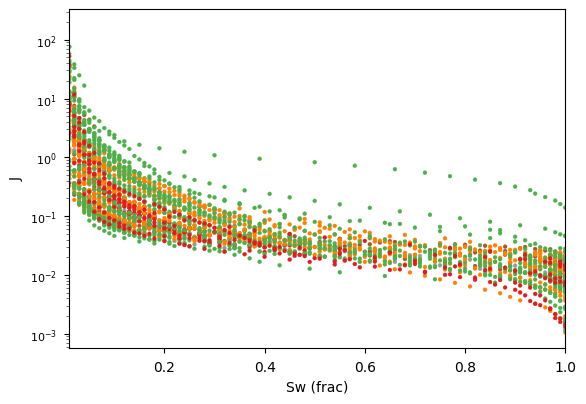

In [4]:
from quick_pp.core_calibration import leverett_j, j_xplot

ift = 485
theta = 140

core_data['J'] = leverett_j(core_data['PC'], ift, theta, core_data['CPERM'], core_data['CPORE'])
j_xplot(core_data['SW'], core_data['J'], core_group=core_data['ROCK_FLAG'])


c:\projects\quick_pp\notebooks\..\quick_pp\core_calibration.py:88: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(sw, j, marker='.', c=core_group, cmap='Set1')


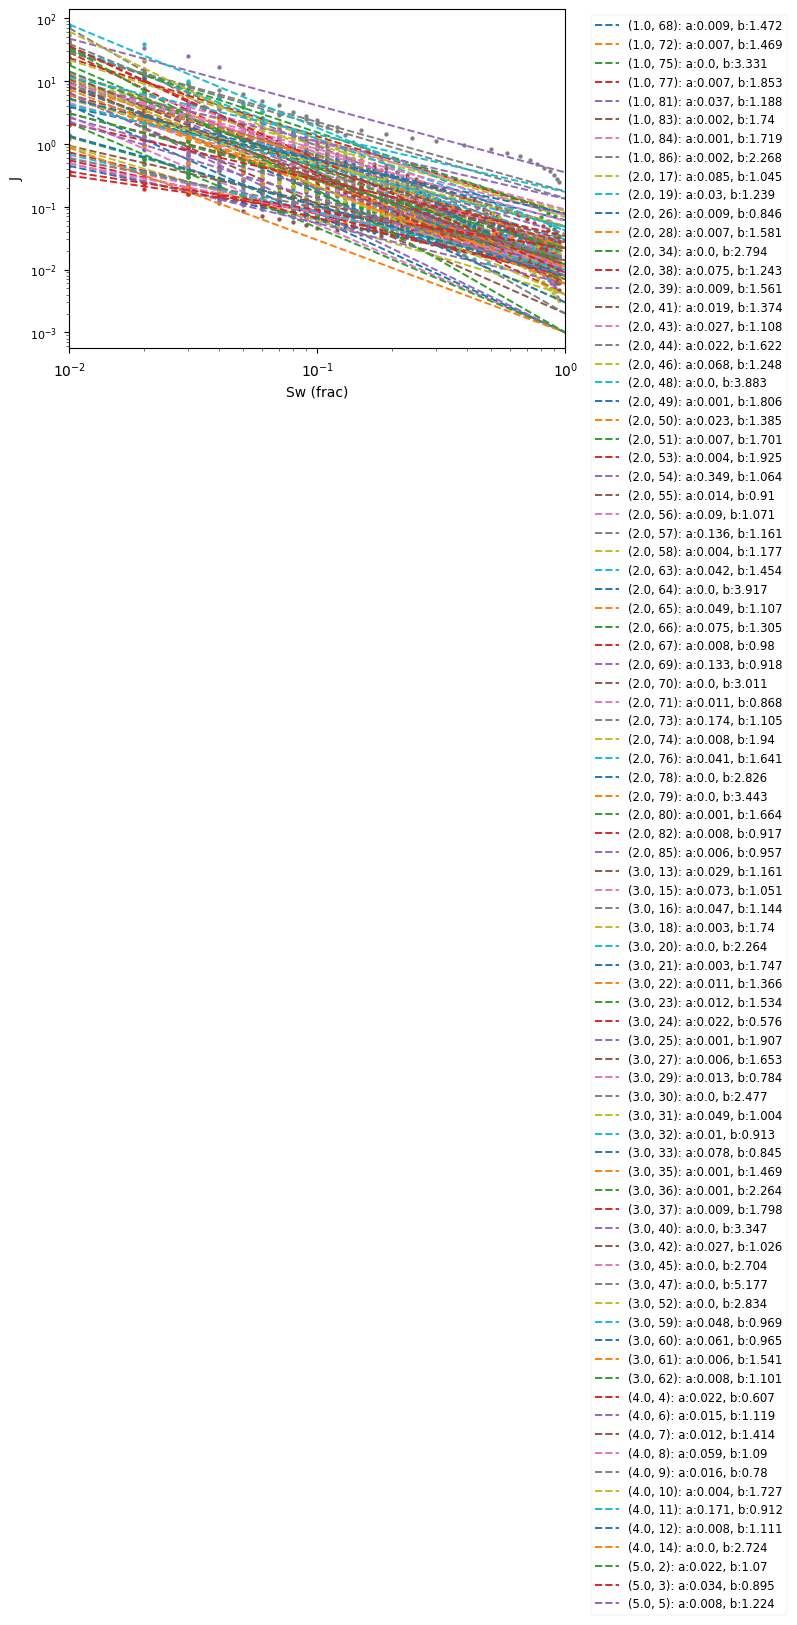

In [5]:
from quick_pp.core_calibration import fit_j_curve, j_xplot

for rt, data in core_data.groupby(['ROCK_FLAG', 'Sample']):
    data = data[(data['SW'] < 0.95) & (data['SW'] > .0)]
    a, b = fit_j_curve(data['SW'], data['J'])
    j_xplot(data['SW'], data['J'], a=a, b=b,
            label=f'{rt}: a:{a}, b:{b}', log_log=True)

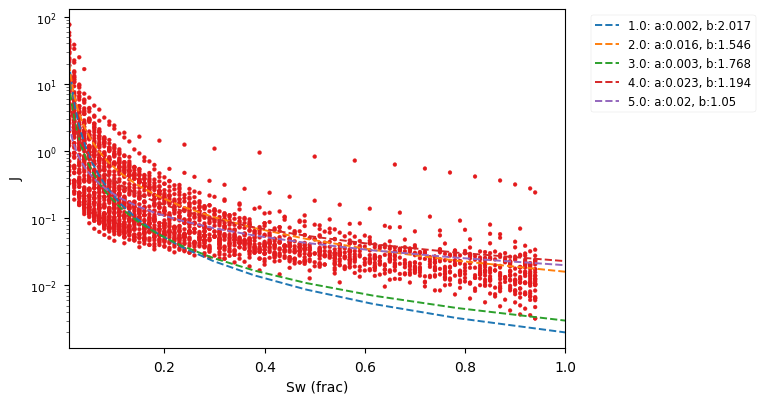

In [6]:
from quick_pp.core_calibration import fit_j_curve, j_xplot

for rt, data in core_data.groupby('ROCK_FLAG'):
    data = data[(data['SW'] < 0.95) & (data['SW'] > .0)]
    a, b = fit_j_curve(data['SW'], data['J'])
    j_xplot(data['SW'], data['J'], a=a, b=b, core_group=data['ROCK_FLAG'],
            label=f'{rt}: a:{a}, b:{b}', log_log=False)

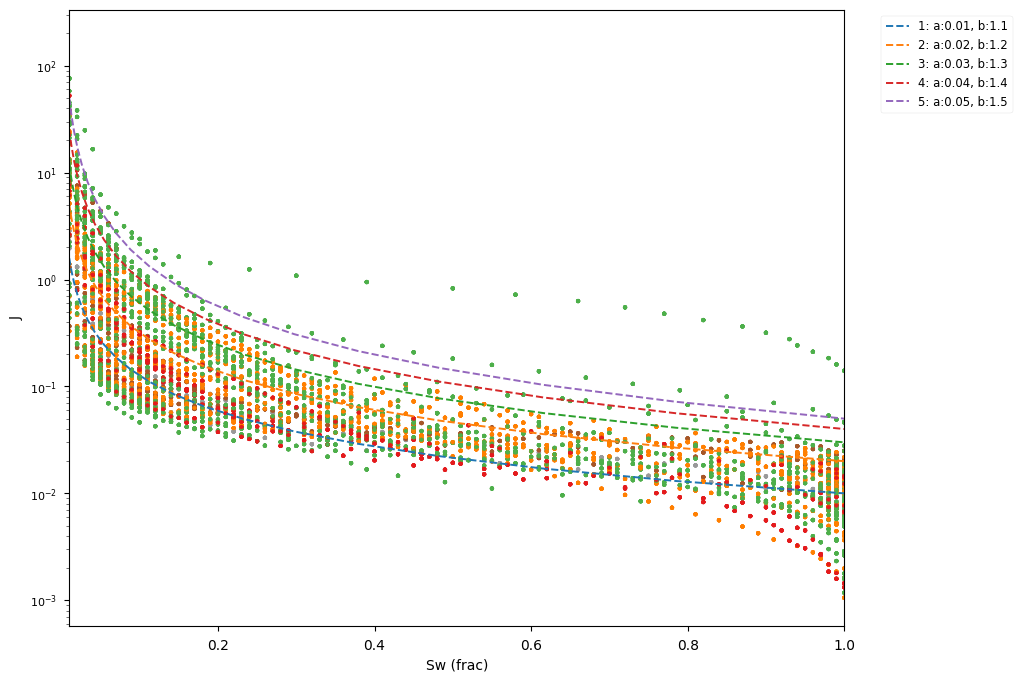

In [31]:
import matplotlib.pyplot as plt
from quick_pp.core_calibration import fit_j_curve, j_xplot

params = {
    1: (.01, 1.1),
    2: (.02, 1.2),
    3: (.03, 1.3),
    4: (.04, 1.4),
    5: (.05, 1.5)
}

temp_data = core_data[core_data['SW'] < .9]
plt.figure(figsize=(10, 8))
for rt, param in params.items():
    a, b = param
    j_xplot(core_data['SW'], core_data['J'], a=a, b=b, core_group=core_data['ROCK_FLAG'],
            label=f'{rt}: a:{a}, b:{b}', log_log=False)

## Estimate SHF

In [8]:
from quick_pp.objects import Project

# Load well from saved file
project = "MOCK_carbonate"
project_path = rf"data\04_project\{project}.qppp"
project = Project().load(project_path)
project.get_well_names()

all_data = project.get_all_data()

(0.0, 1.0)

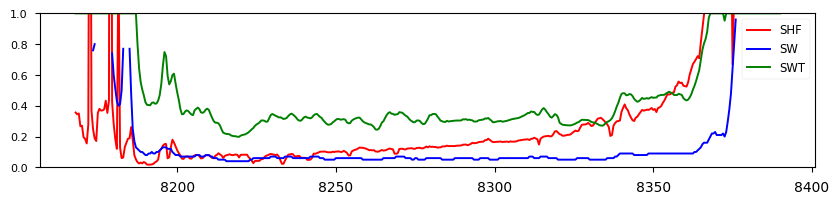

In [83]:
from quick_pp.core_calibration import sw_shf_leverett_j

params = {
    1: (.01, 1.1),
    2: (.02, 1.2),
    3: (.03, 1.3),
    4: (.04, 1.4),
    5: (.05, 1.5)
}

ift = 485
theta = 130
ghc = .837
gw = 1.0
fwl=8380

well_data = all_data[all_data.WELL_NAME == 'HW-29'].copy()

well_data['a'] = .01  # well_data['ROCK_FLAG'].map(params).apply(lambda x: x[0])
well_data['b'] = 1.1  # well_data['ROCK_FLAG'].map(params).apply(lambda x: x[1])
well_data['SHF'] = sw_shf_leverett_j(
    well_data['PERM'], well_data['PHIT'], well_data['DEPTH'], gw=gw, ghc=ghc,
    fwl=fwl, ift=ift, theta=theta, a=well_data['a'], b=well_data['b'])

plt.figure(figsize=(10, 2))
plt.plot(well_data['DEPTH'], well_data['SHF'], label='SHF', c='r')
plt.plot(well_data['DEPTH'], well_data['SW'], label='SW', c='b')
plt.plot(well_data['DEPTH'], well_data['SWT'], label='SWT', c='g')
plt.legend()
plt.ylim(0, 1)


## Estimate Water Saturation

In [ ]:
# Debug water saturation
water_salinity = 5000
m = args['sw_m']

temp_grad = estimate_temperature_gradient(well_data['DEPTH'], 'imperial')
rw = estimate_rw_temperature_salinity(temp_grad, water_salinity)
qv = estimate_qv(vclw, phit, cec_clay=.1)

swt = waxman_smits_saturation(well_data['RT'], rw, phit, qv)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(20, 4))

ax1.plot(well_data.DEPTH, qv, label='Qv')
ax1.set_ylim(-1, 10)
ax1.legend()

ax2.plot(well_data.DEPTH, well_data['RT'], label='RT')
ax2.plot(well_data.DEPTH, rw, label='rw_salinity')
ax2.plot(well_data.DEPTH, rw, label='rw')
ax2.set_yscale('log')
ax2.legend()

ax3.plot(well_data.DEPTH, swt, label='SWT')
ax3.legend()

fig.tight_layout()

## Predict SWT and SHF and plot the results

In [79]:
from quick_pp.plotter import plotly_log
from quick_pp.rock_type import calc_fzi_perm

# Plot individual results
# well_data = all_data[all_data.WELL_NAME == 'HW-29'].copy()
fig = plotly_log(well_data, '')
fig.show(config=dict(scrollZoom=True))